### setup

In [1]:
import os
import matplotlib as mpl
if os.environ.get('DISPLAY','') == '':
    print('no display found. Using non-interactive Agg backend')
    mpl.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
import math
import time
import pickle
from copy import deepcopy

import numpy as np

import sklearn.preprocessing as pre
from sklearn.model_selection import train_test_split
from sklearn import manifold
from sklearn.metrics.pairwise import euclidean_distances

from scipy.linalg import orthogonal_procrustes
from scipy.linalg import eigh

from collections import OrderedDict

import mdtraj as md




In [2]:
showPlots=1
useMagics=1
if useMagics:
    %matplotlib inline
    #%matplotlib notebook
    %load_ext autoreload
    %autoreload 2'''

In [3]:
# fix random seed for reproducibility
randstate = 200184
np.random.seed(randstate)

## Takens h2t diffusion map

534743
534742


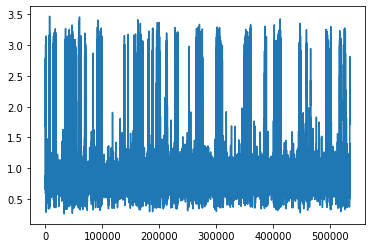

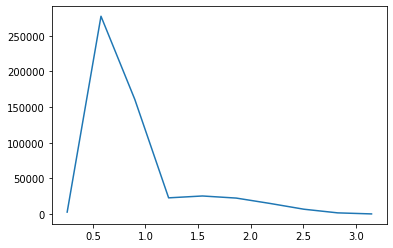

	Processed model 1/60
534743
534742


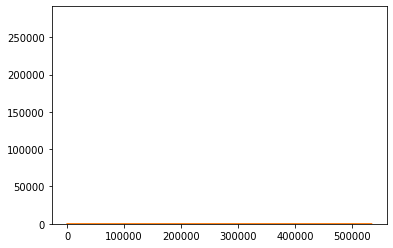

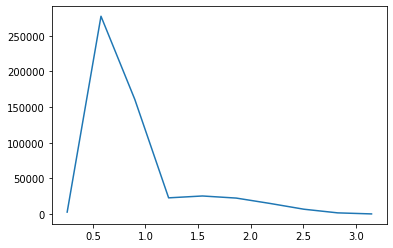

	Processed model 2/60
534743
534742


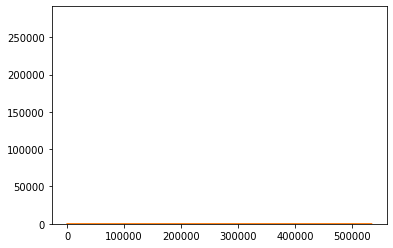

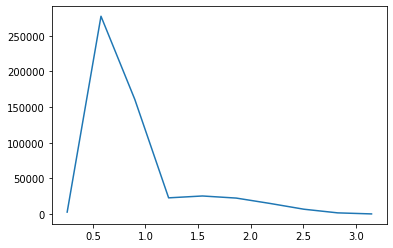

	Processed model 3/60
534743
534742


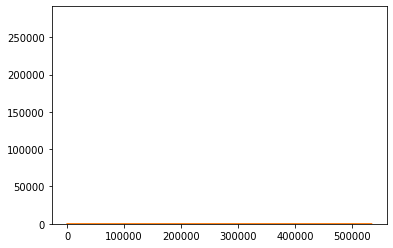

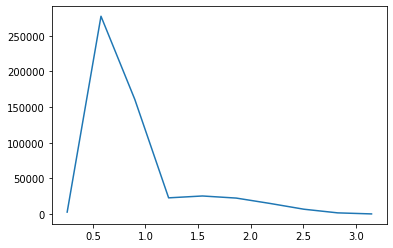

	Processed model 4/60
534743
534738


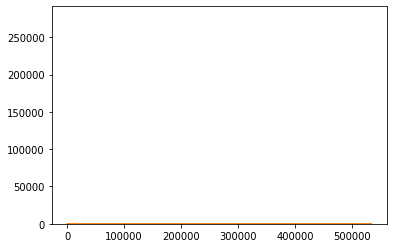

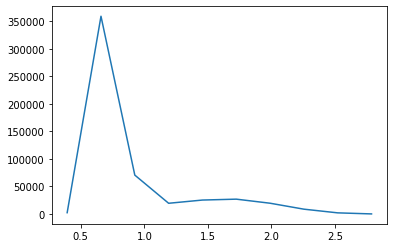

	Processed model 5/60
534743
534738


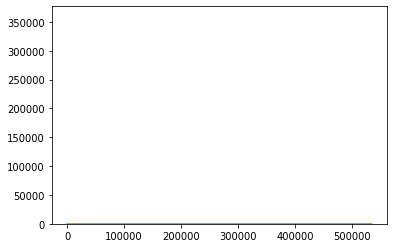

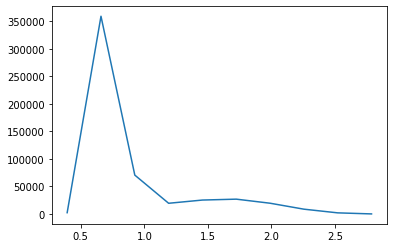

	Processed model 6/60
534743
534738


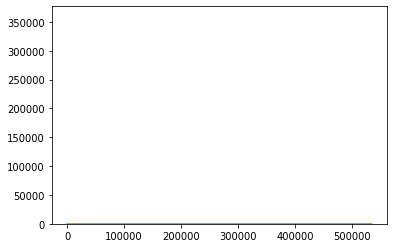

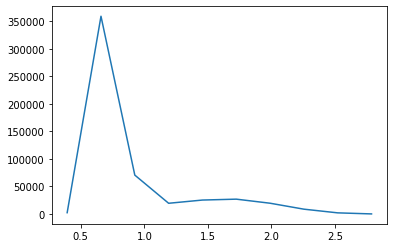

	Processed model 7/60
534743
534738


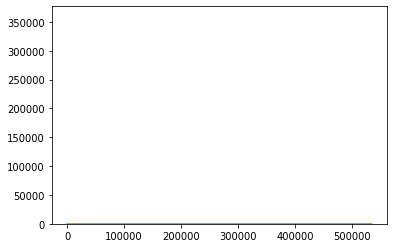

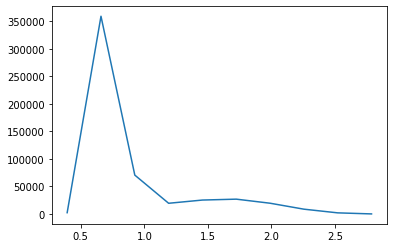

	Processed model 8/60
534743
534733


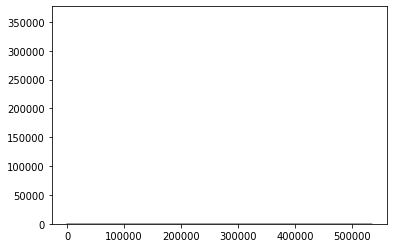

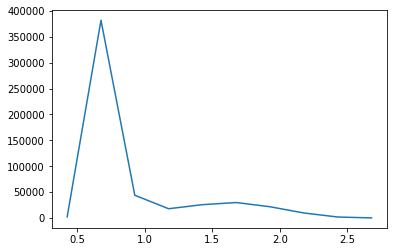

	Processed model 9/60
534743
534733


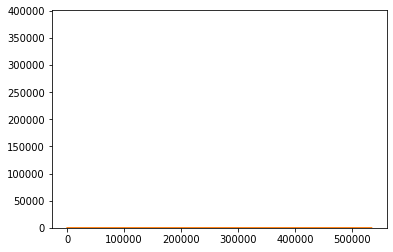

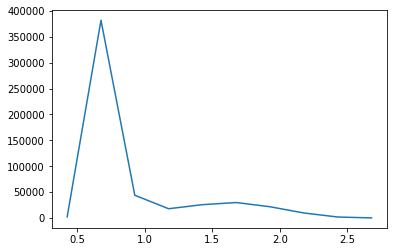

	Processed model 10/60
534743
534733


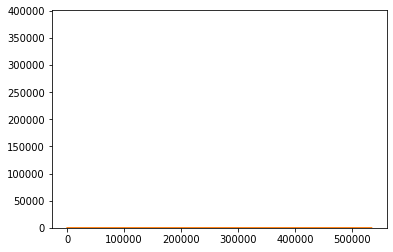

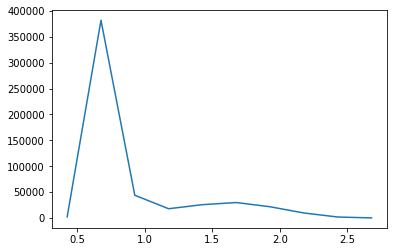

	Processed model 11/60
534743
534733


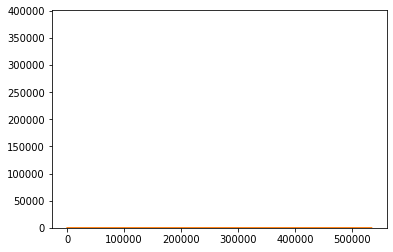

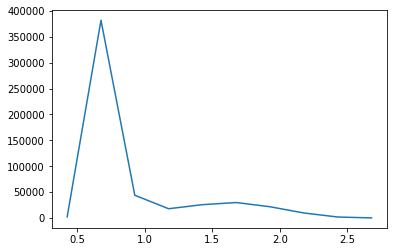

	Processed model 12/60
534743
534718


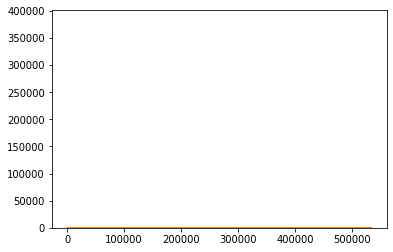

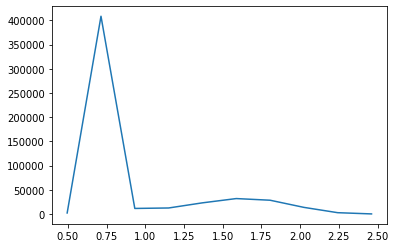

	Processed model 13/60
534743
534718


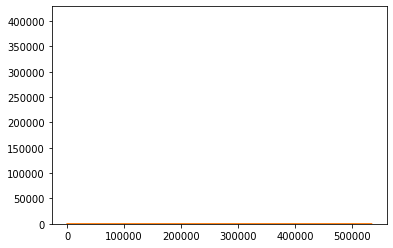

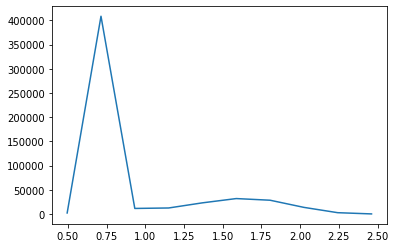

	Processed model 14/60
534743
534718


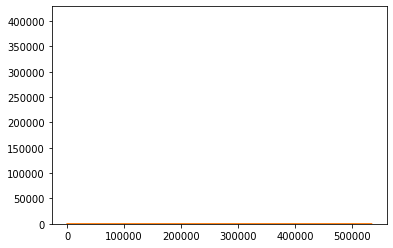

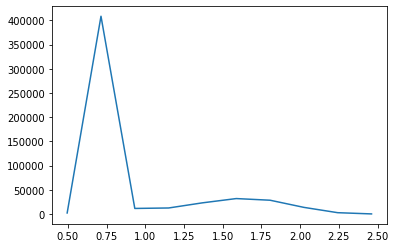

	Processed model 15/60
534743
534718


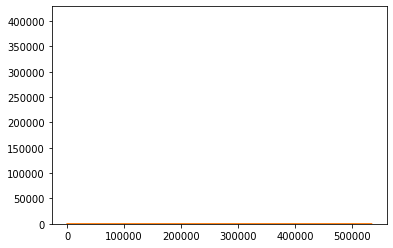

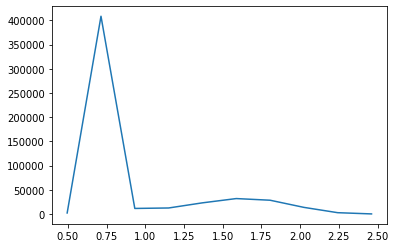

	Processed model 16/60
534743
534693


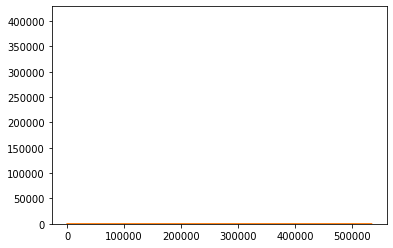

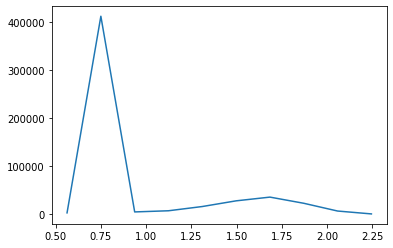

	Processed model 17/60
534743
534693


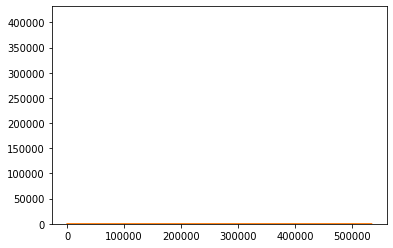

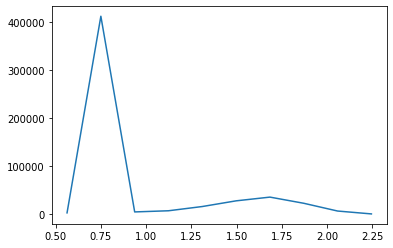

	Processed model 18/60
534743
534693


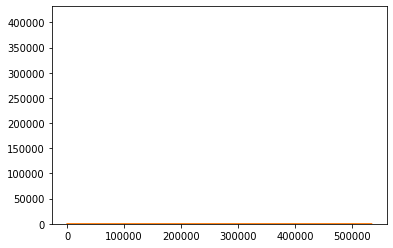

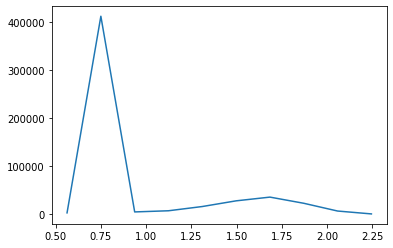

	Processed model 19/60
534743
534693


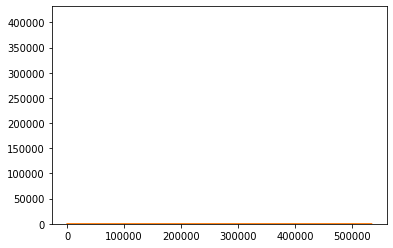

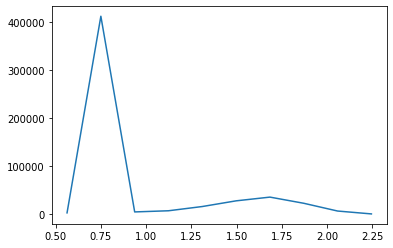

	Processed model 20/60
534743
534742


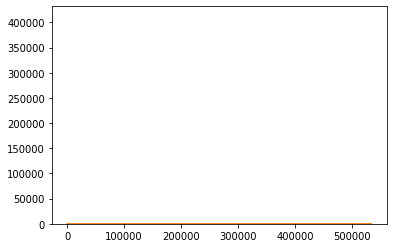

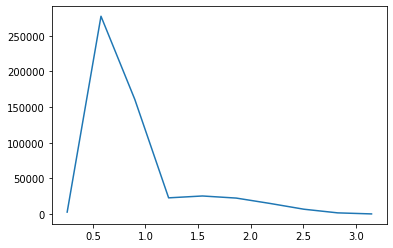

	Processed model 21/60
534743
534742


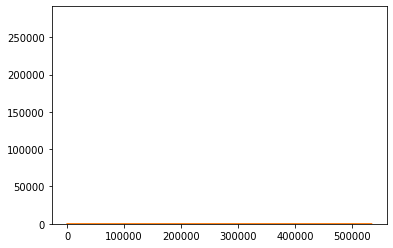

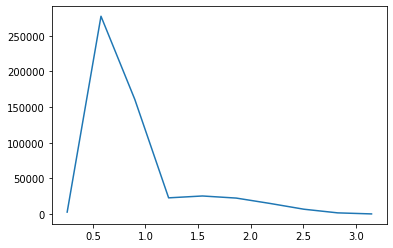

	Processed model 22/60
534743
534742


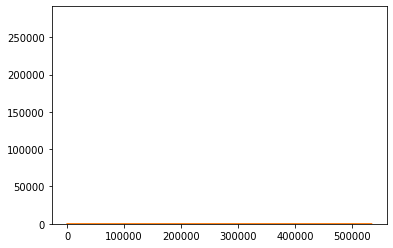

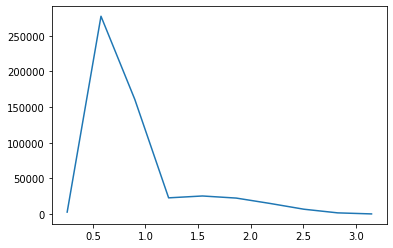

	Processed model 23/60
534743
534742


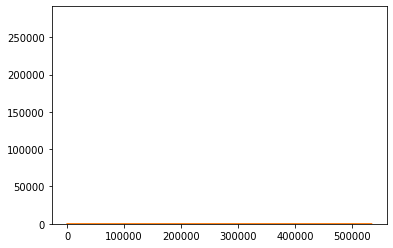

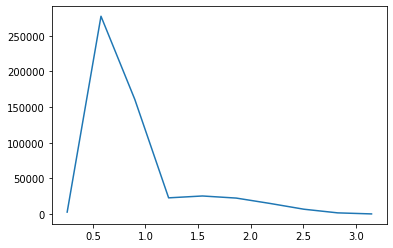

	Processed model 24/60
534743
534738


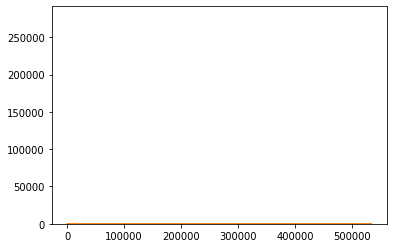

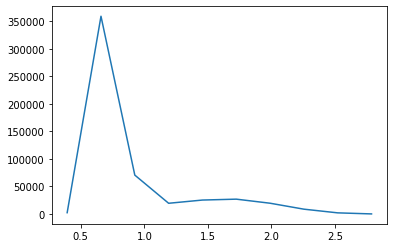

	Processed model 25/60
534743
534738


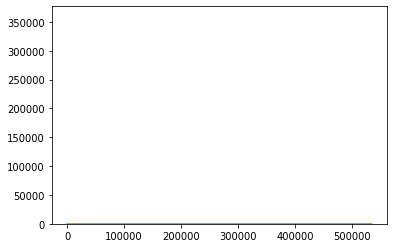

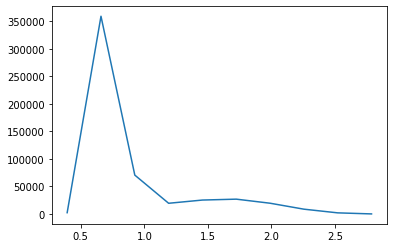

	Processed model 26/60
534743
534738


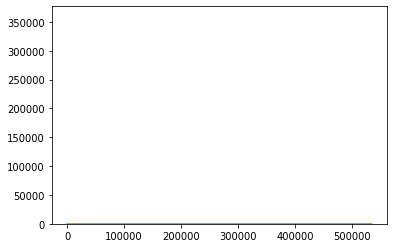

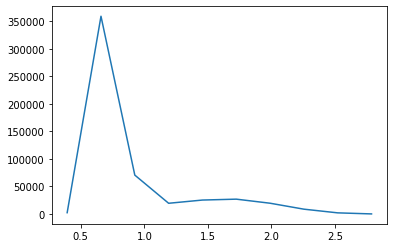

	Processed model 27/60
534743
534738


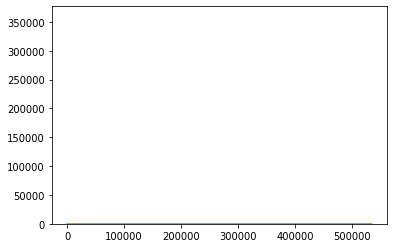

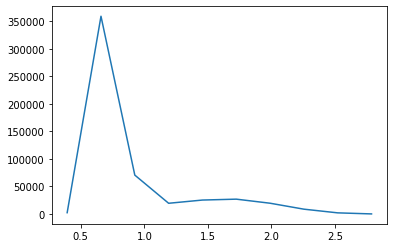

	Processed model 28/60
534743
534733


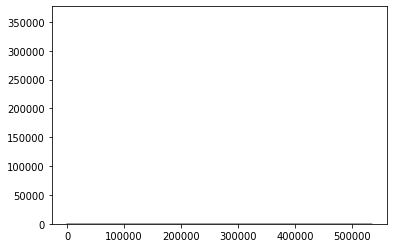

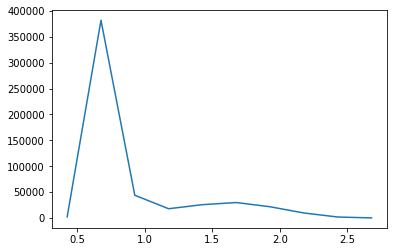

	Processed model 29/60
534743
534733


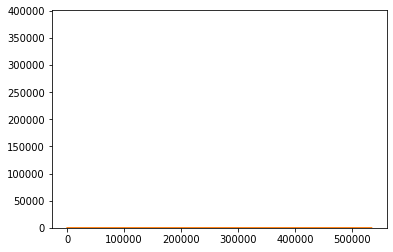

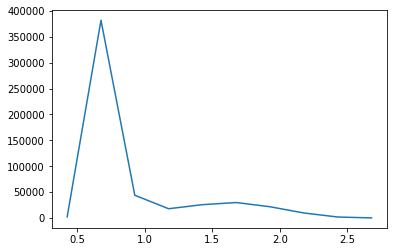

	Processed model 30/60
534743
534733


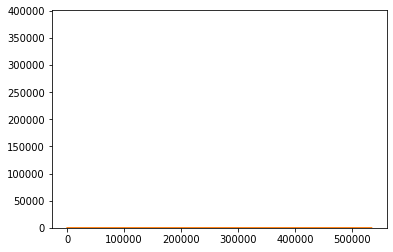

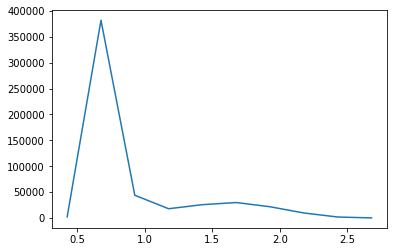

	Processed model 31/60
534743
534733


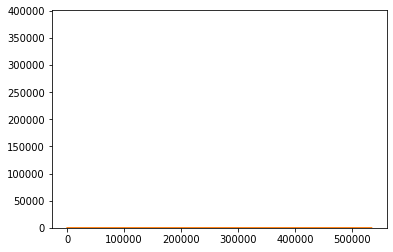

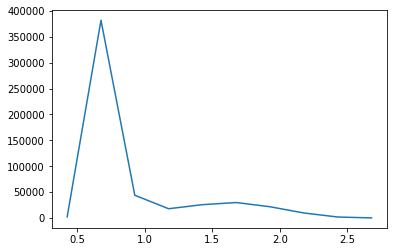

	Processed model 32/60
534743
534718


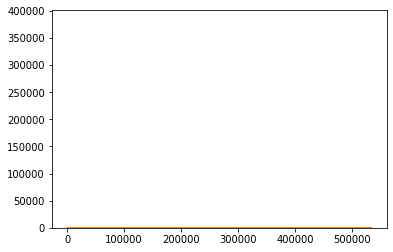

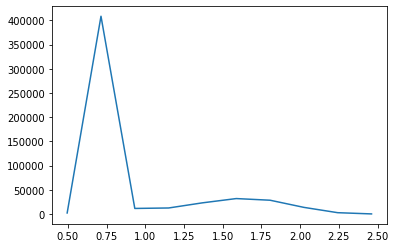

	Processed model 33/60
534743
534718


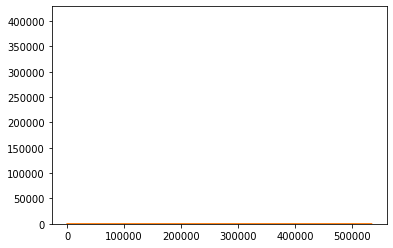

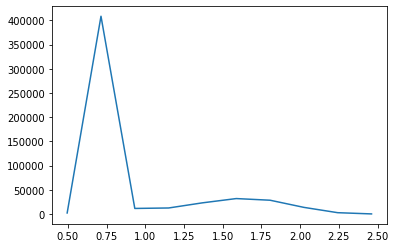

	Processed model 34/60
534743
534718


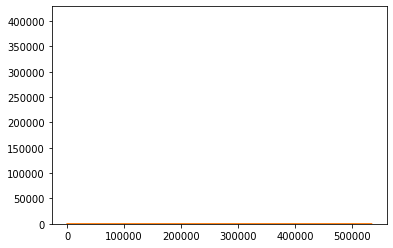

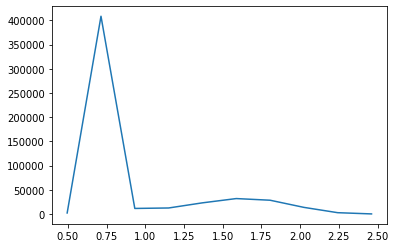

	Processed model 35/60
534743
534718


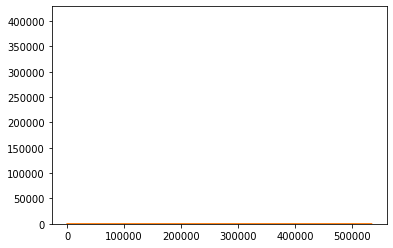

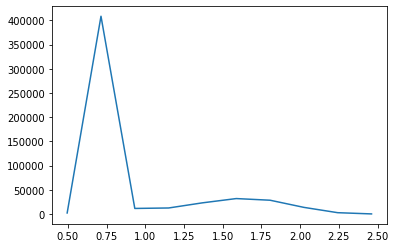

	Processed model 36/60
534743
534693


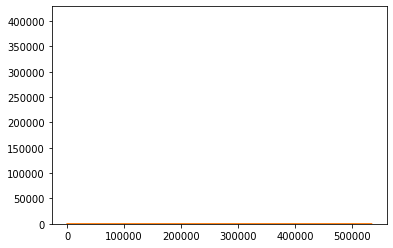

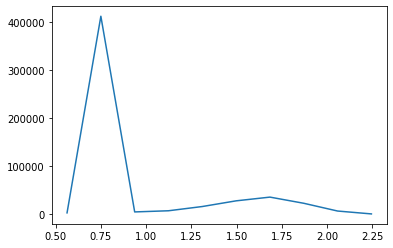

	Processed model 37/60
534743
534693


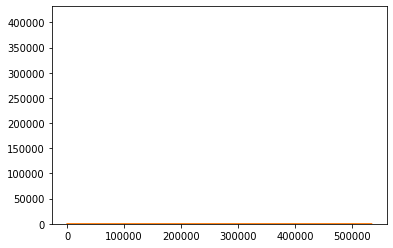

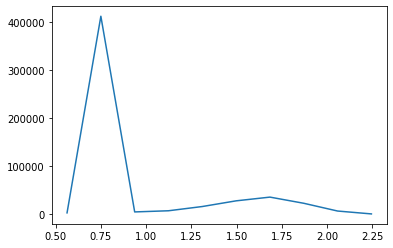

	Processed model 38/60
534743
534693


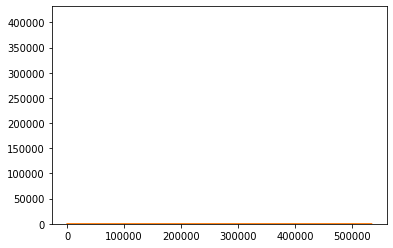

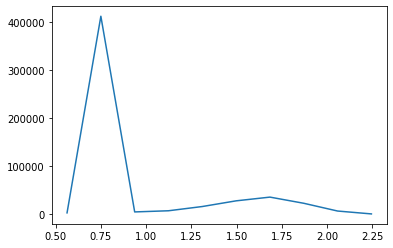

	Processed model 39/60
534743
534693


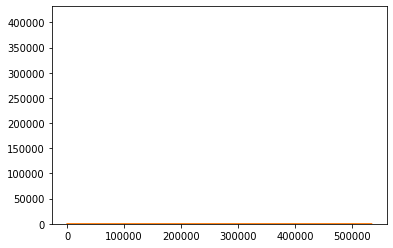

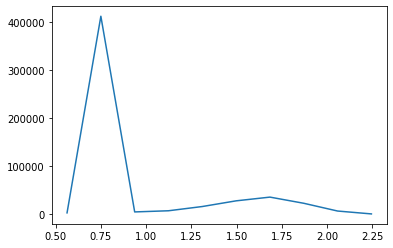

	Processed model 40/60
534743
534742


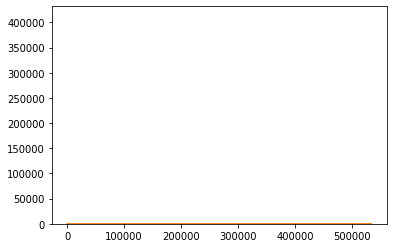

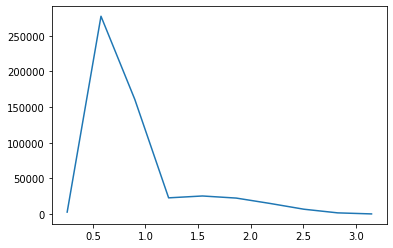

	Processed model 41/60
534743
534742


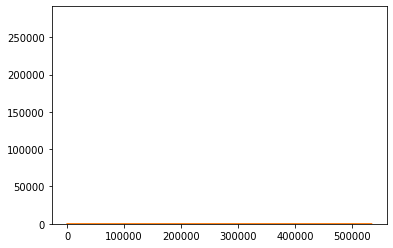

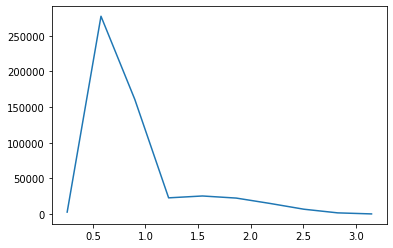

	Processed model 42/60
534743
534742


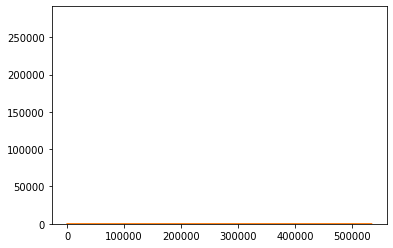

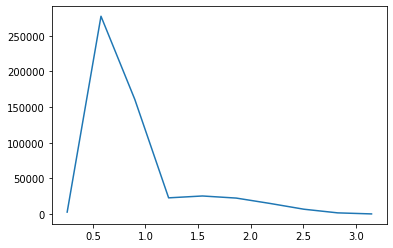

	Processed model 43/60
534743
534742


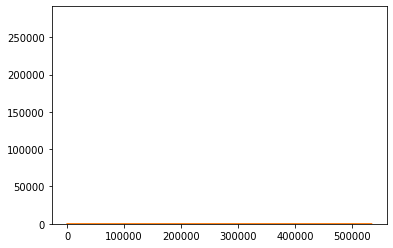

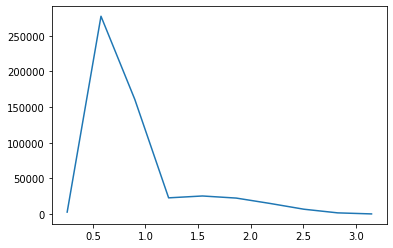

	Processed model 44/60
534743
534738


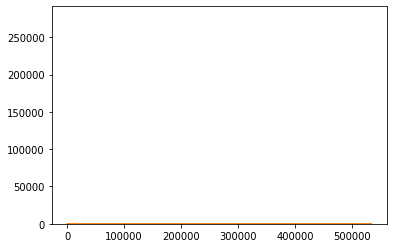

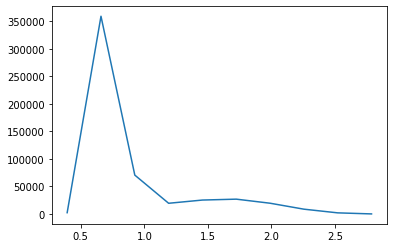

	Processed model 45/60
534743
534738


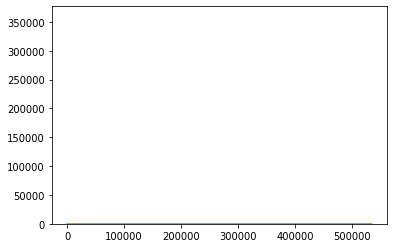

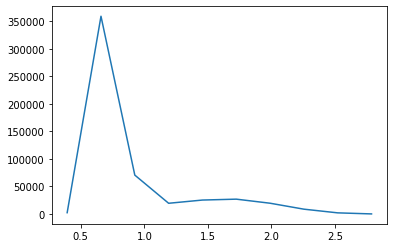

	Processed model 46/60
534743
534738


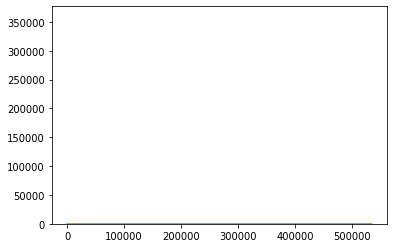

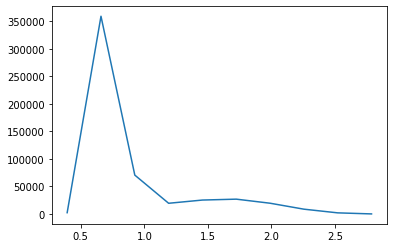

	Processed model 47/60
534743
534738


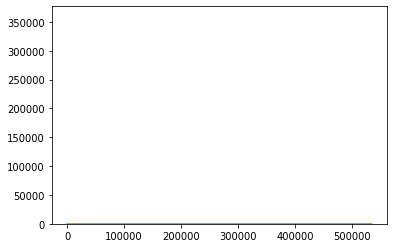

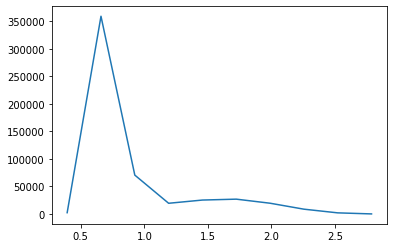

	Processed model 48/60
534743
534733


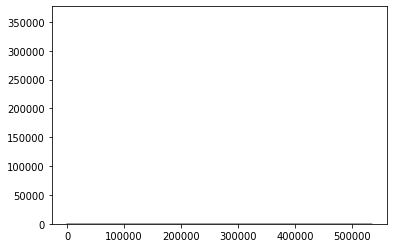

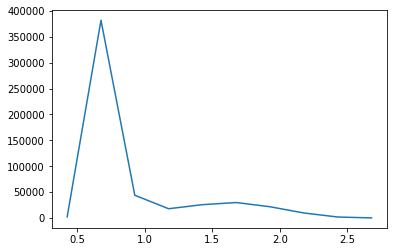

	Processed model 49/60
534743
534733


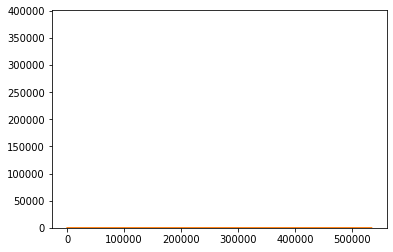

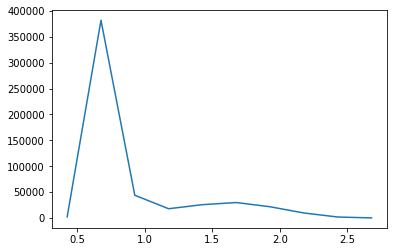

	Processed model 50/60
534743
534733


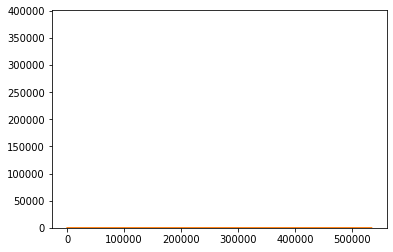

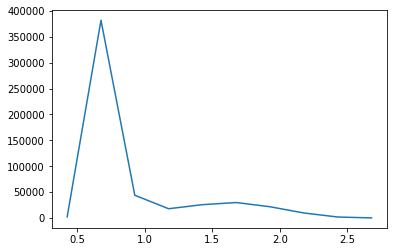

	Processed model 51/60
534743
534733


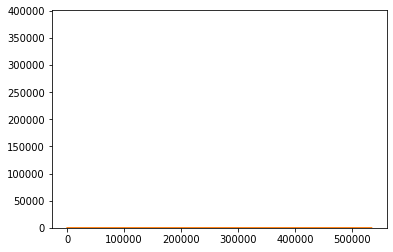

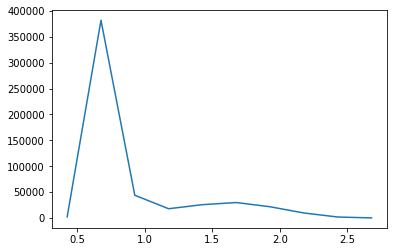

	Processed model 52/60
534743
534718


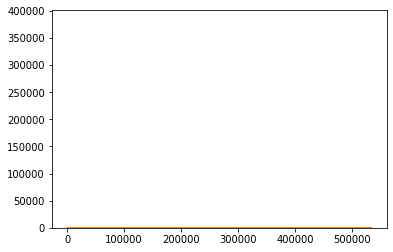

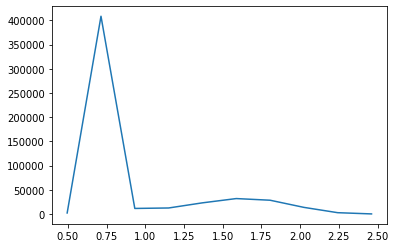

	Processed model 53/60
534743
534718


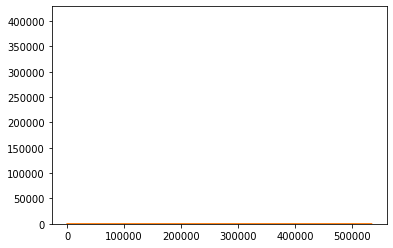

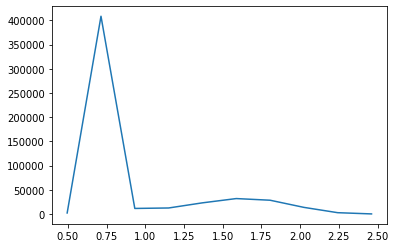

	Processed model 54/60
534743
534718


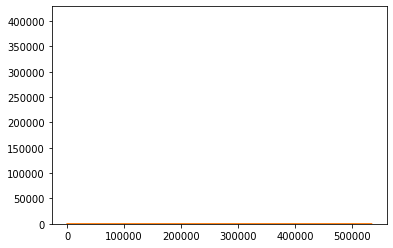

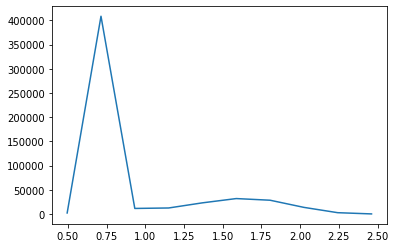

	Processed model 55/60
534743
534718


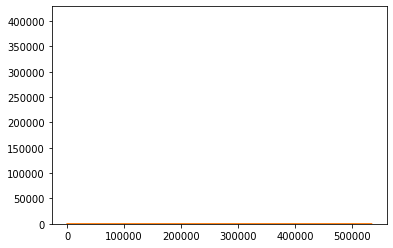

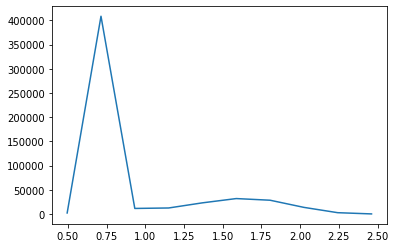

	Processed model 56/60
534743
534693


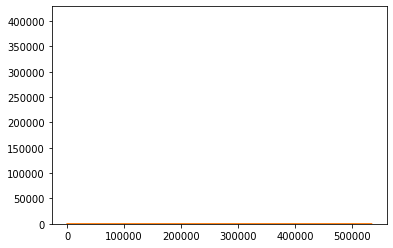

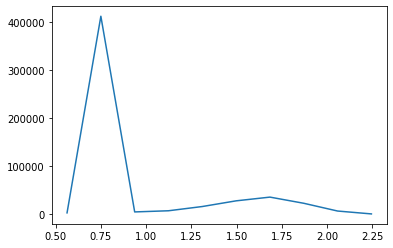

	Processed model 57/60
534743
534693


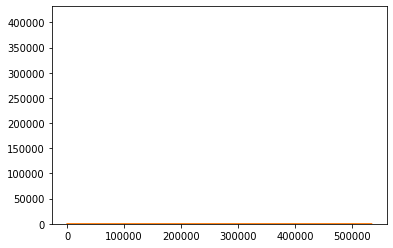

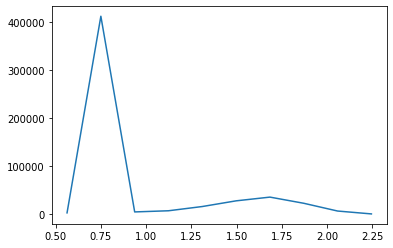

	Processed model 58/60
534743
534693


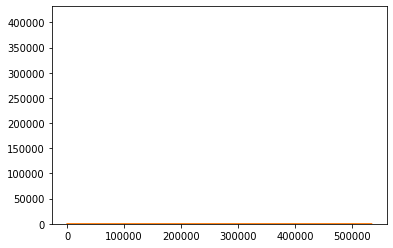

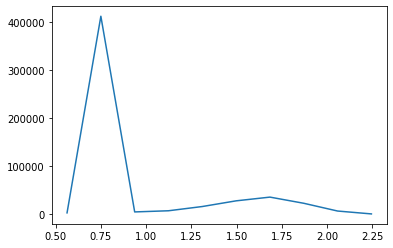

	Processed model 59/60
534743
534693


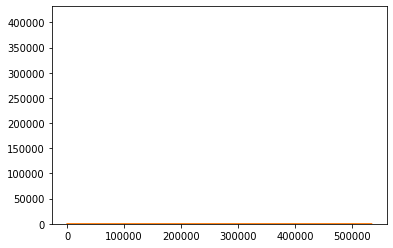

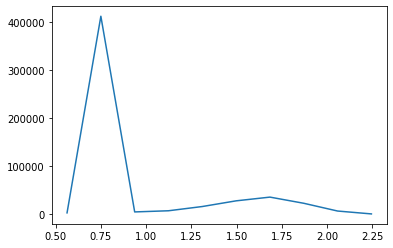

	Processed model 60/60


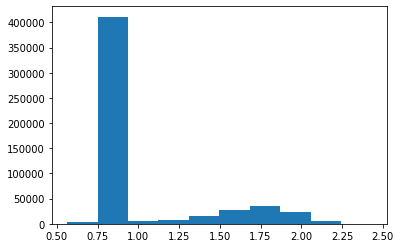

In [4]:
R_0 = 5
phi_D = 1
phi_A = 1
def var(R_0,r,phi_D,phi_A,I_D):
    return (((r**2) * (((R_0/r)**6)+1) * (1+((r/R_0)**6)*(phi_D/phi_A) ))/(36*I_D))


#DELAY SIZES:
#DONE 1,40000,1000000
#none, 1ns, 10ns, 100ns
#tau = [1,5,10,25,50]

# 1, all complete

tau = [1,5,10,25,50]

Dvec = [40000,20000,10000,1000] #20000,10000,1000
#,20000,10000,1000


#no of observed photons
#Photon_No  = [0,1000000,100000,10000,1000]

Photon_No  = [0,1000000,100000,10000]#,100000,10000,1000]



#CRASHED ON 5,5,5000 so missing 4-5,5-1,5000 and 3,1,5000

#need to run

iii = 0

for Dv in Dvec:
    for t in tau:
        for Nv in Photon_No:
    
            trj_file = '../../Short Circuit/0A_aa_h2t/trj_%fns.xtc' %(t*0.2)
            pdb_file = '../../Short Circuit/0A_aa_h2t/trj_init%fns.pdb' %(t*0.2)

            # loading
            traj = md.load(trj_file, top=pdb_file)

            print(len(traj))

           # npzfile = np.load('../0A_aa_h2t/princMom_%fns.npz' %(t*0.2)) 
            #sorted(npzfile.files)
            #princMom = npzfile['princMom']
            #Rg = npzfile['Rg']

            #print(princMom.shape)
            #print(Rg.shape) 
            npzfile = np.load('../../Short Circuit/0A_aa_h2t/h2t_%fns.npz' %(t*0.2)) 
            sorted(npzfile.files)
            h2t = npzfile['h2t_train']

            print(len(h2t))
            plt.plot(h2t)
            plt.show()
            no = list(np.histogram(h2t,bins=10)[0])
            val = list(np.histogram(h2t,bins=10)[1][0:10])
            plt.plot(val,no)
            plt.show()
            plt.hist(h2t)

            indx = []
            dim = 11
            j = 0
            # Train in 40k data points
            stopframe = Dv
            #Chose over first 450000
            totframe = int(round(len(h2t)*0.8))
            # number of pieces
            nohist = 10
            #train 10 percent on each ile
            ratio = 1/nohist
            #print(stopframe,totframe)

            #find histogram values
            no = list(np.histogram(h2t[0:totframe],bins=nohist)[0])
            val = list(np.histogram(h2t[0:totframe],bins=nohist)[1][0:nohist])
            val.insert(0,0)

            #print(len(h2t), val)
            #iterate over the number of histogram divisions
            for ile in range(nohist):
                #print(ile)
                # iterate over all frames
                for i in range(totframe):
                    #iterate over deciles
                    #print(stopframe*ratio*(ile+1))
                    if j < stopframe*ratio*(ile+1):
                        # select that it is in the correct decile
                        if h2t[i] < val[ile+1] and h2t[i] > val[ile]:
                            for d in range(-dim//2+1,dim//2+1):
                                if (i+d) not in indx:
                                    #print(i-d)
                                    indx.append(i+d)
                                    j += 1
                                    #print(i-d)
                                    #print(indx[])

                    elif j >= stopframe:
                        #print(ile,i,j)
                        break

             #   print(len(indx))
                
                
                
            
                
                
            #INSERT NOISE      
            noisy_h2t = deepcopy(h2t)

            if Nv != 0:
                for i in range(len(noisy_h2t)):
                    noisy_h2t[i] += (np.random.normal(0,np.sqrt(var(R_0,h2t[i],phi_D,phi_A,Nv))))

                np.savez('noisy_h2t_%dk_%dphoton_%fns.npz' %(Dv,Nv,t*0.2), noisy_h2t=noisy_h2t)
            #h2t = noisy_h2t



            # DELAY VECS

            nFrames = len(noisy_h2t)
            dim = 11
            nObs = len(noisy_h2t)
            #print(nObs)
            startFrame = 0
            stopFrame = len(noisy_h2t)
            skipper = 1
            noisy_h2t = noisy_h2t[startFrame:stopFrame:skipper]

            # constructing delay vectors
            delayVecs = np.reshape(noisy_h2t[0:len(noisy_h2t)-(dim-1)*t],(len(noisy_h2t)-(dim-1)*t,1))
            for ii in range(1,dim):
                delayVecs = np.concatenate((delayVecs,np.reshape(noisy_h2t[ii*t:len(noisy_h2t)-(dim-1)*t+ii*t],(len(noisy_h2t)-(dim-1)*t,1))), axis=1)

            nVecs = delayVecs.shape[0]

            delayVecs_ss = deepcopy(delayVecs[indx])
            #princMom_ss = princMom[indx]
            #Rg_ss = Rg[indx]
            h2t_ss = noisy_h2t[indx]
            delayVecs_ss_flip = np.fliplr(delayVecs_ss)


            N = delayVecs_ss.shape[0]

            P = np.minimum( euclidean_distances(delayVecs_ss,delayVecs_ss), euclidean_distances(delayVecs_ss_flip,delayVecs_ss) )
            #print(N)

            np.savez('P_%dk_%dphoton_%fns.npz' %(Dv,Nv,t*0.2), P=P)

            # scanning
            log_eps_array = np.arange(-6,6,1)
            sumA = np.empty_like(log_eps_array)

            for i in range(len(log_eps_array)):
                eps = np.exp(log_eps_array[i])
                sumA[i] = np.sum(np.exp(-P**2/(2*eps)),axis=None)



            # plotting
            fig, ax = plt.subplots()
            ax.scatter(log_eps_array, np.log(sumA))
            ax.plot([log_eps_array[0],log_eps_array[-1]],[np.log(N**2),np.log(N**2)],'k:')
            ax.plot([log_eps_array[0],log_eps_array[-1]],[np.log(N),np.log(N)],'k:')
            ax.set_xlabel("log(eps)")
            ax.set_ylabel("log(sumA)")
            fig.savefig('eps_%dk_%dphoton_%fns.png' %(Dv,Nv,t*0.2), dpi=300)
            plt.close()

            eps = np.exp(0)
            # print(eps)
            # dMaps

            P = np.exp(-P**2/(2*eps))
            D = np.sum(P,axis=1)
            P = np.matmul(np.matmul(np.diag(D**(-0.5)),P),np.diag(D**(-0.5))) # constructing Ms as symmetric matrix for diagonalization

            #assert np.allclose(P, P.T)

            nEvals=20
            lamb, psi = eigh(P,eigvals=(P.shape[0]-nEvals,P.shape[0]-1)) # scipy eigh to specify only computation of leading evals
            psi = np.matmul(np.diag(D**(-0.5)),psi) # converting evecs of Ms to evecs of M; M and Ms share evals

            idx_sort = np.flip(np.argsort(lamb))

            lamb = lamb[idx_sort]
            psi = psi[:,idx_sort]

            np.savez('map_%dk_%dphoton_%fns.npz' %(Dv,Nv,t*0.2), lamb=lamb, psi=psi,delayVecs_ss=delayVecs_ss,delayVecs_ss_flip=delayVecs_ss_flip, eps=eps )



            # plotting eval spectrum
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.bar(np.arange(1,len(lamb)), lamb[1:])
            ax.set_xlabel('eval idx')
            ax.set_ylabel('eval')
            plt.xticks(np.arange(1, len(lamb), step=1))
            fig.savefig('evals_%dk_%dphoton_%fns.png' %(Dv,Nv,t*0.2), dpi=300)
            plt.close()

            # Nystrom extension applied to all frames in data set

            z = []
            for i in range(delayVecs.shape[0]):
                Euc_i = np.minimum( euclidean_distances(delayVecs_ss,delayVecs[i].reshape(1,-1)), euclidean_distances(delayVecs_ss_flip,delayVecs[i].reshape(1,-1)) )

                Euc_i = np.exp(-Euc_i**2/(2*eps))

                Euc_i /= np.sum(Euc_i)

                psi_Nystrom = np.divide( np.matmul(Euc_i.T,psi), lamb)

                z.append(psi_Nystrom)

            z = np.array(z)
            z = z.reshape(z.shape[0],-1)
            # saving dMap embedding of all data
            np.savez('data_%dk_%dphoton_%fns.npz' %(Dv,Nv,t*0.2), z=z)
            iii +=1
            print('\tProcessed model %d/%d' % (iii,len(tau)*len(Dvec)*len(Photon_No)))

In [5]:
dim = 11
for d in range(-dim//2+1,dim//2+1):
    print(d)

-5
-4
-3
-2
-1
0
1
2
3
4
5


pdb_dir = "/home/maxtopel/Desktop/History/Gaussian Mol Rec/mol rec/Chignolin_partial/"
pdb_file = os.path.join(pdb_dir, "system.pdb")

trj_dir = "/home/maxtopel/Desktop/History/Gaussian Mol Rec/mol rec/Chignolin_partial/CLN2025-0-protein/"
trj_file = []
for i in range(10):
    fname = "CLN025-0-protein-00" + str(i) + ".dcd"
    trj_file.append(os.path.join(trj_dir, fname))
for i in range(10,54):
    fname = "CLN025-0-protein-0" + str(i) + ".dcd"
    trj_file.append(os.path.join(trj_dir, fname))
    
# loading
traj = md.load(trj_file, top=pdb_file)

# restricting atoms in trajectory
idx_atoms = traj.topology.select_atom_indices('heavy') # 'heavy' OR 'minimal' OR 'all'
traj = traj.atom_slice(idx_atoms)
# rot+trans alignment of trajectory to first frame
traj.center_coordinates(mass_weighted=False)
traj.superpose(traj[0])

#npzfile = np.load('../../Chignolin_partial/princMom.npz')
#sorted(npzfile.files)
#princMom = npzfile['princMom']
#Rg = npzfile['Rg']

